Download db files from https://www.kaggle.com/datasets/algorismus/adventure-works-in-excel-tables/data

In [1]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sqlite3

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3


In [3]:
pip install matplotlib --upgrade

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sqlite3
connection = sqlite3.connect("AdventureWorks2022.db")
connection.close()

In [5]:
import sqlite3
import pandas as pd
import glob
import os

def load_csv_to_sqlite(filename, table_name, database_file):
    connection = sqlite3.connect(database_file)
    print(filename,table_name,database_file)
    with open(filename, 'r') as f:
        data = pd.read_csv(f, delimiter='\t')
        #print(data)
        data.to_sql(table_name, connection, if_exists='append', index=False)

    connection.commit()
    connection.close()

# Load the CSV files into the AdventureWorks2022.db database
database_file = 'AdventureWorks2022.db'

# Load all CSV files in the "AdventureWorks2022" directory
for filename in glob.glob('AdventureWorks2022/*.csv'):
  
    table_name = os.path.basename(filename).replace('.csv', '')
    load_csv_to_sqlite(filename, table_name, database_file)


AdventureWorks2022\Product.csv Product AdventureWorks2022.db
AdventureWorks2022\Region.csv Region AdventureWorks2022.db
AdventureWorks2022\Reseller.csv Reseller AdventureWorks2022.db
AdventureWorks2022\Sales.csv Sales AdventureWorks2022.db
AdventureWorks2022\Salesperson.csv Salesperson AdventureWorks2022.db
AdventureWorks2022\SalespersonRegion.csv SalespersonRegion AdventureWorks2022.db
AdventureWorks2022\Targets.csv Targets AdventureWorks2022.db


In [6]:
#Verifying the tables
import sqlite3

connection = sqlite3.connect('AdventureWorks2022.db')
cursor = connection.cursor()

cursor.execute('SELECT name FROM sqlite_master WHERE type = "table";')
tables = cursor.fetchall()

for table in tables:
    print(table[0])

connection.close()


Product
Region
Reseller
Sales
Salesperson
SalespersonRegion
Targets


In [7]:

from sqlalchemy import create_engine,inspect
from sqlalchemy.orm import sessionmaker


# Connect to the AdventureWorks2022 database.
engine = create_engine('sqlite:///AdventureWorks2022.db')
Session = sessionmaker(bind=engine)
session = Session()

In [8]:
# Create an inspector to gather information about the database
inspector = inspect(engine)

# Step 1: Get a list of tables in the database
tables = inspector.get_table_names()
print('Database overview:')
print('\n##############################################################\n')
print("Total number of tables in the database:",len(tables))
# Print the list of tables
print("\nTables in AdventureWorks 2022:")
for table in tables:
    print(f"- {table}")

Database overview:

##############################################################

Total number of tables in the database: 7

Tables in AdventureWorks 2022:
- Product
- Region
- Reseller
- Sales
- Salesperson
- SalespersonRegion
- Targets


In [28]:
# descriptive summary of the AdventureWorks2022 database
#Check each table and its columns in the list of tables
for table in tables:
    # Fetch some data for analysis
    query_product_data =  f"SELECT * FROM {table} LIMIT 5"
    product_data = pd.read_sql_query(query_product_data, engine)

    # Display the columns
    columns = product_data.columns.tolist()
    print(f"{table} table Columns:",columns)
    
    # Display the fetched data
    print(f"\nSample data from the {table} table:\n",product_data,"\n")
    print(f"\n############################################################################\n")

    
 #Close the database connection
engine.dispose()

Product table Columns: ['ProductKey', 'Product', 'Standard Cost', 'Color', 'Subcategory', 'Category', 'Background Color Format', 'Font Color Format']

Sample data from the Product table:
    ProductKey                    Product Standard Cost  Color  Subcategory  \
0         210  HL Road Frame - Black, 58       $868.63  Black  Road Frames   
1         215    Sport-100 Helmet, Black        $12.03  Black      Helmets   
2         216    Sport-100 Helmet, Black        $13.88  Black      Helmets   
3         217    Sport-100 Helmet, Black        $13.09  Black      Helmets   
4         253  LL Road Frame - Black, 58        $176.2  Black  Road Frames   

      Category Background Color Format Font Color Format  
0   Components                 #000000           #FFFFFF  
1  Accessories                 #000000           #FFFFFF  
2  Accessories                 #000000           #FFFFFF  
3  Accessories                 #000000           #FFFFFF  
4   Components                 #000000          

In [10]:

query = f"SELECT count(DISTINCT Category) AS NumProductCategories FROM Product;"
NumProductCategories = pd.read_sql_query(query,engine)
print("Number of product categories:\n",NumProductCategories)
query = f"SELECT AVG(CAST(REPLACE([Standard Cost], '$', '') AS DECIMAL(10,2))) AS AverageStandardCost FROM Product"
AverageProductPrice = pd.read_sql_query(query,engine)
print("\nAverage product price:$\n",AverageProductPrice)


Number of product categories:
    NumProductCategories
0                     4

Average product price:$
    AverageStandardCost
0           246.933149


In [11]:
# Visualizations to demonstrate interesting aspects of the data

# Get the average sales amount for each product category
query1="""
SELECT Category, AVG(CAST(REPLACE(Sales, '$', '') AS DECIMAL(10,2))) AS AvgSales
FROM Product
LEFT JOIN Sales
ON Product.ProductKey = Sales.ProductKey
GROUP BY Category;
"""
query = """SELECT
    p.Category,
    AVG(CAST(REPLACE(s.Sales, '$', '') AS DECIMAL(10,2))) AS AverageSalesAmount
FROM
    Sales s
JOIN
    Product p ON s.ProductKey = p.ProductKey
JOIN
    SalespersonRegion sr ON s.SalesTerritoryKey = sr.SalesTerritoryKey
GROUP BY
    p.Category;"""
average_sales_per_category= pd.read_sql_query(query,engine)
print("average sales amount per product category:\n",average_sales_per_category)

average sales amount per product category:
       Category  AverageSalesAmount
0  Accessories          104.317308
1        Bikes          188.555491
2     Clothing          143.274604
3   Components          269.897313


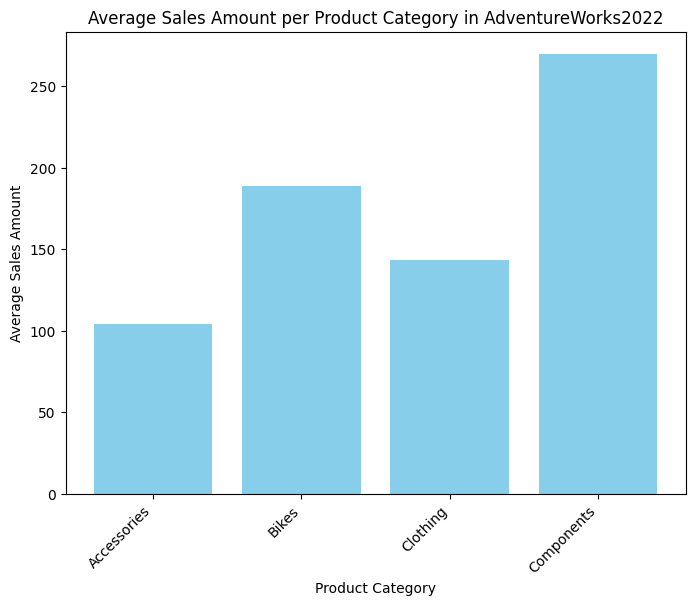

In [12]:
import matplotlib.pyplot as plt
# Perform some visualizations
# # Bar chart
plt.figure(figsize=(8, 6))
plt.bar(average_sales_per_category['Category'], average_sales_per_category['AverageSalesAmount'], color='skyblue')
plt.xlabel('Product Category')
plt.ylabel('Average Sales Amount')
plt.title('Average Sales Amount per Product Category in AdventureWorks2022')
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
query = """
SELECT Title
FROM Salesperson
GROUP BY Title
ORDER BY COUNT(Title) DESC
LIMIT 1;
"""
emp_title= pd.read_sql_query(query,engine)
print("Most common employee title:\n",emp_title)

Most common employee title:
                   Title
0  Sales Representative


In [14]:
#number of employees for each job title
query = """
SELECT
    s.Title,
    COUNT(DISTINCT s.EmployeeID) AS NumberOfEmployees
FROM
    Salesperson s
GROUP BY
    s.Title;
"""

# result into a DataFrame
number_of_employees_per_job_title = pd.read_sql_query(query, engine)

# Display the result
print(number_of_employees_per_job_title)

                          Title  NumberOfEmployees
0             Director of Sales                  1
1        European Sales Manager                  1
2  North American Sales Manager                  1
3         Pacific Sales Manager                  1
4          Sales Representative                 14


In [15]:
# Get the number of Emplyees in each country

query = """
SELECT
    r.Country AS Country,
    COUNT(DISTINCT sp.EmployeeKey) AS NumberOfEmployees
FROM
    SalespersonRegion sp
JOIN
    Region r ON sp.SalesTerritoryKey = r.SalesTerritoryKey
GROUP BY
    r.Country;
"""
empl_count_per_country = pd.read_sql_query(query,engine)
print("No of Employees in each Country:",empl_count_per_country)



No of Employees in each Country:           Country  NumberOfEmployees
0       Australia                  3
1          Canada                  4
2          France                  4
3         Germany                  3
4  United Kingdom                  3
5   United States                 10


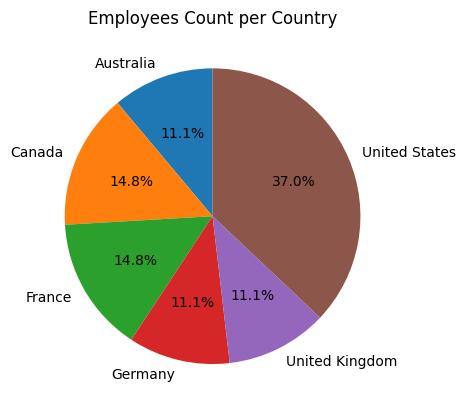

In [16]:
# Create a pie chart of the emplyess count per country
sizes=empl_count_per_country['NumberOfEmployees']
labels=empl_count_per_country['Country']
# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Employees Count per Country')
plt.show()

In [17]:
#get the sales of different products

query = """SELECT Sales.ProductKey, Sales, CAST(REPLACE([Unit Price], '$', '') AS DECIMAL(10,2)) * Quantity AS TotalSales
FROM Sales
JOIN Product ON Sales.ProductKey = Product.ProductKey;
"""
sale_count_per_product = pd.read_sql_query(query,engine)
print("No of Sales per product:\n",sale_count_per_product)

No of Sales per product:
         ProductKey      Sales  TotalSales
0              235     $57.68       57.68
1              235     $57.68       57.68
2              235     $57.68       57.68
3              351  $4,049.98        4.00
4              351  $4,049.98        4.00
...            ...        ...         ...
520654         482    $113.62      113.62
520655         482    $113.62      113.62
520656         474       $910      910.00
520657         474       $910      910.00
520658         474       $910      910.00

[520659 rows x 3 columns]


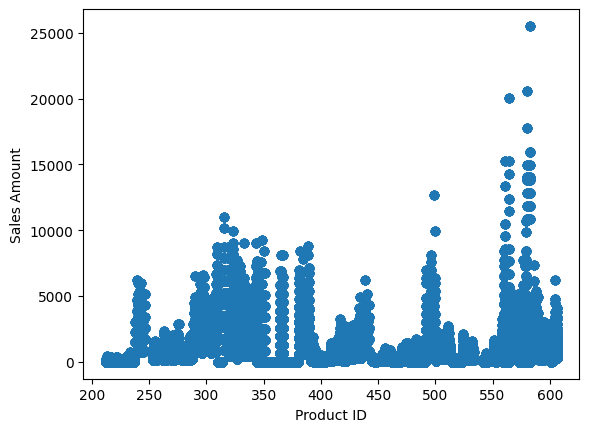

In [18]:
# Create a scatter plot of the sales
plt.scatter(sale_count_per_product.ProductKey, sale_count_per_product.TotalSales)
plt.xlabel('Product ID')
plt.ylabel('Sales Amount')
plt.show()

In [19]:
import pandas as pd


# Create a DataFrame from the data
data = {
    "Job Title": ["Production Technician - WC45", "Sales Representative", "Buyers", "Marketing Specialist", "Scheduling Assistant", "Quality Assurance Technician"],
    "note": [15, 14, 9, 5, 4, 4]
}
df = pd.DataFrame(data)

# Calculate the mean and standard deviation of the note column
mean = df['note'].mean()
std_dev = df['note'].std()

print(f'Mean: {mean:.2f}')
print(f'Standard Deviation: {std_dev:.2f}')

Mean: 8.50
Standard Deviation: 5.01


In [20]:
# Statistical analysis

print(df['note'].describe())

count     6.00000
mean      8.50000
std       5.00999
min       4.00000
25%       4.25000
50%       7.00000
75%      12.75000
max      15.00000
Name: note, dtype: float64


This code snippet reads the data from the JobTitles table in the AdventureWorks2022 database into a Pandas DataFrame. It then calculates the mean and standard deviation of the note column.

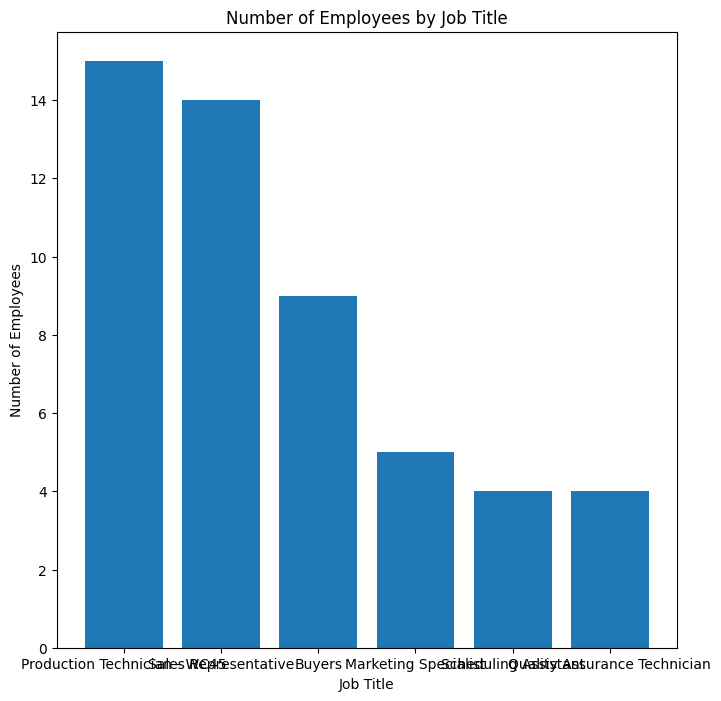

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame from the data
data = {
    "Job Title": ["Production Technician - WC45", "Sales Representative", "Buyers", "Marketing Specialist", "Scheduling Assistant", "Quality Assurance Technician"],
    "note": [15, 14, 9, 5, 4, 4]
}
df = pd.DataFrame(data)


# Create a bar chart of the number of employees for each job title
plt.figure(figsize=(8,8))
plt.bar(df['Job Title'], df['note'])
plt.xlabel('Job Title')
plt.ylabel('Number of Employees')
plt.title('Number of Employees by Job Title')
plt.show()

# Confidence interval
mean = df['note'].mean()
std = df['note'].std()

In [22]:
# Confidence interval
mean = df['note'].mean()
std = df['note'].std()
#This code snippet calculates the 95% confidence interval for the mean of the note column. It assumes that the sample is normally distributed.
confidence_level = 0.95

margin_of_error = std * 1.96 * (1 / df['note'].count()) ** 0.5
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")


95% Confidence Interval: [4.49, 12.51]
